# Design Codes
This example demonstrates how to work with design codes. We start by importing the necessary modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from concreteproperties.design_codes import AS3600
import concreteproperties.stress_strain_profile as ssp
from sectionproperties.pre.library.concrete_sections import concrete_rectangular_section
from concreteproperties.concrete_section import ConcreteSection
from concreteproperties.results import MomentInteractionResults

## Create Design Code and Materials
In this example we'll use the AS 3600:2018 design code. 40 MPa concrete will be used with the default 500N steel.

In [2]:
design_code = AS3600()
concrete = design_code.create_concrete_material(compressive_strength=40)
steel = design_code.create_steel_material()

We can confirm the concrete material properties.

40 MPa Concrete (AS 3600:2018)
Density = 2.4e-06 kg/mm^3


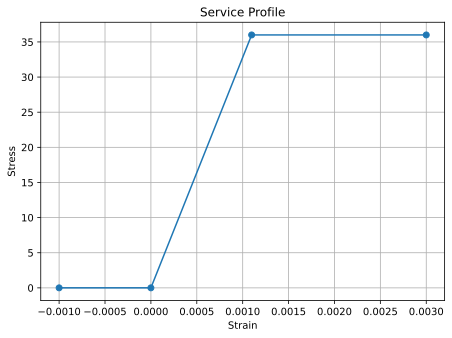

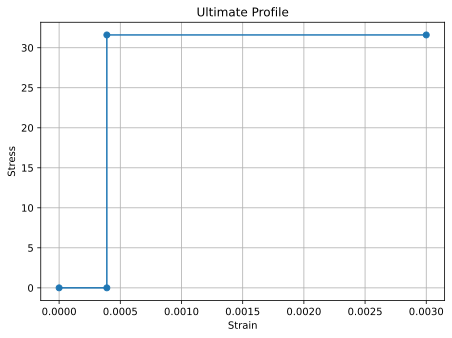

Concrete Flexural Tensile Strength: 3.79 MPa


In [3]:
print(concrete.name)
print(f"Density = {concrete.density} kg/mm^3")
concrete.stress_strain_profile.plot_stress_strain(title="Service Profile")
concrete.ultimate_stress_strain_profile.plot_stress_strain(title="Ultimate Profile")
print(
    f"Concrete Flexural Tensile Strength: {concrete.flexural_tensile_strength:.2f} MPa"
)

We can confirm the steel material properties.

500 MPa Steel (AS 3600:2018)
Density = 7.85e-06 kg/mm^3


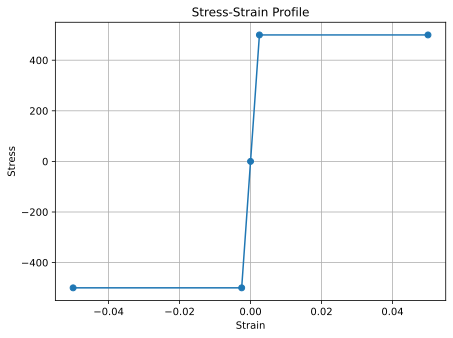

<AxesSubplot:title={'center':'Stress-Strain Profile'}, xlabel='Strain', ylabel='Stress'>

In [4]:
print(steel.name)
print(f"Density = {steel.density} kg/mm^3")
steel.stress_strain_profile.plot_stress_strain()

## Assign Geometry to Design Code
This example will analyse a 600D x 450W concrete beam with 5N20s top and bottom. After creating the geometry it must be assigned to the design code object.

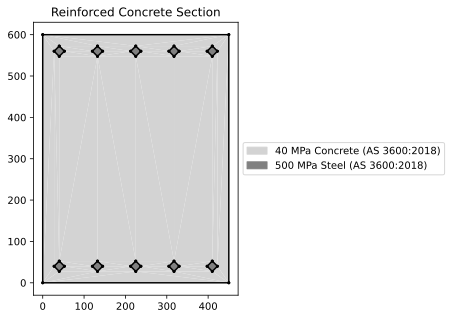

In [5]:
geom = concrete_rectangular_section(
    b=450,
    d=600,
    dia_top=20,
    n_top=5,
    dia_bot=20,
    n_bot=5,
    n_circle=4,
    cover=30,
    area_top=310,
    area_bot=310,
    conc_mat=concrete,
    steel_mat=steel,
)

conc_sec = ConcreteSection(geom)
conc_sec.plot_section()
design_code.assign_concrete_section(concrete_section=conc_sec)

## Area Properties
Obtaining the area properties is identical to that of a ``ConcreteSection`` object. The same can be done for a moment-curvature analysis and stress analyses (not carried out in this example).

In [6]:
gross_props = design_code.get_gross_properties()
transformed_props = design_code.get_transformed_gross_properties(
    elastic_modulus=concrete.stress_strain_profile.elastic_modulus
)
cracked_props = design_code.calculate_cracked_properties()

## Ultimate Bending Capacity
The factored ultimate bending capacity can be found by calling the ``ultimate_bending_capacity()`` method. This method returns a factored and unfactored ``UltimateBendingResults`` object, as well as the capacity reduction factor ``phi``.

In [7]:
f_ult_res, ult_res, phi = design_code.ultimate_bending_capacity()
print(f"Muo = {ult_res.m_xy / 1e6:.2f} kN.m")
print(f"kuo = {ult_res.k_u:.4f}")
print(f"phi = {phi:.3f}")
print(f"phi.Muo = {f_ult_res.m_xy / 1e6:.2f} kN.m")

Muo = 414.19 kN.m
kuo = 0.0898
phi = 0.850
phi.Muo = 352.07 kN.m


We can also pass an axial load to ``ultimate_bending_capacity()``. This will calculate the factored moment capacity by ensuring the supplied axial load equals the factored axial capacity, i.e. given a design axial force, what is the maximum moment my section can handle?

In [8]:
n_star = 1000e3
f_ult_res, ult_res, phi = design_code.ultimate_bending_capacity(n=n_star)
print(f"N* = {n_star / 1e3:.0f} kN")
print(f"Nu = {ult_res.n / 1e3:.2f} kN")
print(f"Mu = {ult_res.m_xy / 1e6:.2f} kN.m")
print(f"phi = {phi:.3f}")
print(f"phi.Nu = {f_ult_res.n / 1e3:.0f} kN")
print(f"phi.Mu = {f_ult_res.m_xy / 1e6:.2f} kN.m")

N* = 1000 kN
Nu = 1312.32 kN
Mu = 724.37 kN.m
phi = 0.762
phi.Nu = 1000 kN
phi.Mu = 551.98 kN.m


## Moment Interaction Diagram
The factored moment interaction diagram can be found by calling the ``moment_interaction_diagram()`` method. This method returns a factored and unfactored ``MomentInteractionResults`` object.

In [9]:
f_mi_res, mi_res, phis = design_code.moment_interaction_diagram()

Output()

We can compare the factored and unfactored moment interaction diagrams.

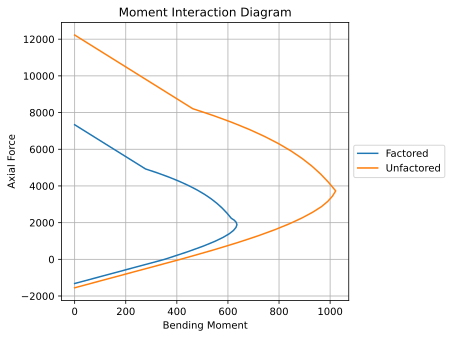

<AxesSubplot:title={'center':'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [10]:
MomentInteractionResults.plot_multiple_diagrams(
    [f_mi_res, mi_res], ["Factored", "Unfactored"], fmt="-"
)

Using the list of capacity reduction factors ``phis``, we can visualise how the capacity reduction factor varies as a function of the applied axial load.

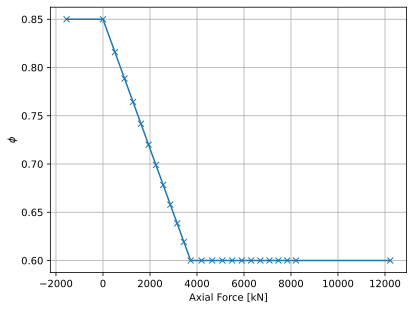

In [11]:
fig, ax = plt.subplots()
n_list, _ = mi_res.get_results_lists(moment="m_x")  # get list of axial loads
ax.plot(np.array(n_list) / 1e3, phis, "-x")
plt.xlabel("Axial Force [kN]")
plt.ylabel("$\phi$")
plt.grid()
plt.show()

We can check to see if a combination of axial force and bending moment lies within the moment interaction diagram using the ``point_in_diagram()`` method.

Case 1: OK
Case 2: FAIL
Case 3: OK
Case 4: OK


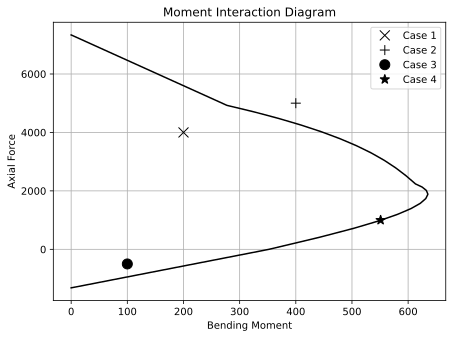

In [12]:
# design load cases
n_stars = [4000e3, 5000e3, -500e3, 1000e3]
m_stars = [200e6, 400e6, 100e6, 551e6]
marker_styles = ["x", "+", "o", "*"]
n_cases = len(n_stars)

# plot moment interaction diagram
ax = f_mi_res.plot_diagram(fmt="k-", render=False)

# check to see if combination is within diagram and plot result
for idx in range(n_cases):
    case = f_mi_res.point_in_diagram(n=n_stars[idx], m=m_stars[idx])
    print("Case {num}: {status}".format(num=idx + 1, status="OK" if case else "FAIL"))
    ax.plot(
        m_stars[idx] / 1e6,
        n_stars[idx] / 1e3,
        "k" + marker_styles[idx],
        markersize=10,
        label=f"Case {idx + 1}",
    )

ax.legend()
plt.show()

Let's compare moment interaction diagrams using a rectangular stress block, a bilinear stress profile and a parabolic stress profile. AS 3600:2018 restricts the maximum stress in the profile to ``0.9 * f'c``.

In [13]:
# bilinear
concrete.ultimate_stress_strain_profile = ssp.BilinearStressStrain(
    compressive_strength=0.9 * 40,
    compressive_strain=0.0015,
    ultimate_strain=0.003,
)
f_mi_res_bil, _, _ = design_code.moment_interaction_diagram()

# parabolic
concrete.ultimate_stress_strain_profile = ssp.EurocodeParabolicUltimate(
    compressive_strength=0.9 * 40,
    compressive_strain=0.0015,
    ultimate_strain=0.003,
    n=2,
)
f_mi_res_par, _, _ = design_code.moment_interaction_diagram()

Output()

Output()

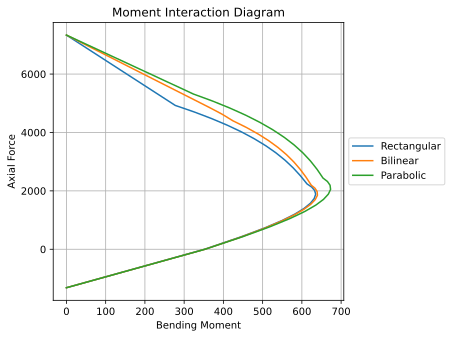

<AxesSubplot:title={'center':'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [14]:
MomentInteractionResults.plot_multiple_diagrams(
    [f_mi_res, f_mi_res_bil, f_mi_res_par],
    ["Rectangular", "Bilinear", "Parabolic"],
    fmt="-",
)

## Biaxial Bending Diagram
We can also compute factored biaxial bending diagrams by calling the ``biaxial_bending_diagram()`` method. This method returns a factored ``BiaxialBendingResults`` object as well as a list of the capacity reduction factors ``phis``.

In [15]:
# reset concrete ultimate profile
concrete.ultimate_stress_strain_profile = ssp.RectangularStressBlock(
    compressive_strength=40,
    alpha=0.79,
    gamma=0.87,
    ultimate_strain=0.003,
)

# create biaxial bending diagram
f_bb_res1, phis1 = design_code.biaxial_bending_diagram()
bb_res1 = conc_sec.biaxial_bending_diagram()
f_bb_res2, phis2 = design_code.biaxial_bending_diagram(n=2000e3)
bb_res2 = conc_sec.biaxial_bending_diagram(n=2000e3)

Output()

Output()

Output()

Output()

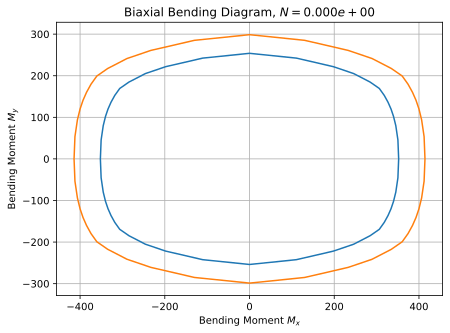

Average phi = 0.850


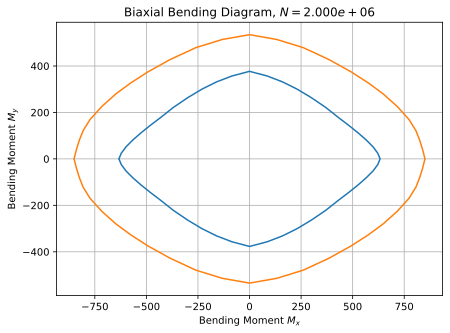

Average phi = 0.618


In [16]:
# plot case 1
ax = f_bb_res1.plot_diagram(fmt="-", render=False)
bb_res1.plot_diagram(fmt="-", ax=ax)
plt.show()
print(f"Average phi = {np.mean(phis1):.3f}")

# plot case 2
ax = f_bb_res2.plot_diagram(fmt="-", render=False)
bb_res2.plot_diagram(fmt="-", ax=ax)
plt.show()
print(f"Average phi = {np.mean(phis2):.3f}")

Note that as the bending angle changes, ``k_uo`` and ``N_ub`` change, resulting in a constantly changing value for ``phi``.